In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
df_basa_full=pd.read_csv('basa_original.csv')

In [3]:
df_basa_full.head()


,depth,cal BP,density,accrate,weight,volume,lycadd,lyc,Abies,Pinus,...,Botrychium,Osmunda,Pteris,Selaginella,Trilete ornamentada,Trilete indeterminada,Chaetomium,Podospora,Sordaria,Sporormiella
0,0.5,-56.90,1.5,0.46,4.3,2.866667,24200,26,1,189,...,0,0,0,0,0,0,0,0,0,0
1,5.5,-50.33,1.7,0.46,3.4,2.000000,24200,12,1,149,...,0,0,0,0,0,0,0,0,0,0
2,10.5,-42.11,1.5,0.46,3.2,2.133333,24200,58,0,206,...,0,0,0,0,0,0,0,1,0,0
3,15.5,-30.47,1.7,0.46,4.0,2.352941,24200,29,0,252,...,0,0,0,1,0,0,0,0,0,0
4,20.5,-13.25,1.7,0.09,3.2,1.882353,24200,17,0,141,...,0,0,0,0,0,0,0,0,0,0


In [3]:
non_aquatic_species = 'Abies,Pinus,Juniperus,Taxus,Betula,Corylus,Alnus,Carpinus,Salix,Ulmus,Populus,Acer,Fraxinus,Fagus,Tilia,Juglans,Castanea,Quercus caducifolio,Quercus perennifolio,Pistacia,Rhamnus,Phillyrea,Buxus,Sambucus,Viburnum,Sanguisorba,Tamarix,Thymelaeaceae,Ephedra distachya,Ephedra fragilis,Ericaceae,Hereda helix,Ilex aquifolium,Viscum album,Lonicera,Vitis,Oleaceae,Myrtus,Olea,Poaceae,Lygeum spartum,Artemisia,Cichorioideae,Asteroideae,Cardueae,Rubiaceae,Centaurea,Chenopodiaceae,Caryophyllaceae,Plantago,Brassicaceae,Saxifragaceae,Fabaceae,Genista,Lotus type,Trifolium type,Rosaceae,Ribes,Boraginaceae,Sedum,Helianthemum,Lamiaceae,Urticaceae,Rumex,Berberidaceae,Euphorbiaceae,Primulaceae,Scrophulariaceae,Papaver,Campanulaceae,Convolvulaceae,Liliaceae,Iridaceae,Crassulaceae,Ranunculaceae,Cistaceae,Galium,Apiaceae,Valerianaceae,Cerealia type,Polygonaceae,Ranunculus'

species_mapping = {
        "Dec_Querc": "Quercus caducifolio",
        "Ever_Querc": "Quercus perennifolio",
        "Ephedra dist": "Ephedra distachya",
        "Ephedra frag": "Ephedra fragilis",
        "Lygeum": "Lygeum spartum",
        "Cicho": "Cichorioideae",
        "Astroi": "Asteroideae",
        "Carduaceae": "Cardueae",
        "Rubiac": "Rubiaceae",
        "Chenopo": "Chenopodiaceae",
        "Caryphy": "Caryophyllaceae",
        "Brassicac": "Brassicaceae",
        "Saxifrag": "Saxifragaceae",
        "Boraginac": "Boraginaceae",
        "Helianthem": "Helianthemum",
        "Euphorbiac": "Euphorbiaceae",
        "Primulac": "Primulaceae",
        "Scrophulari": "Scrophulariaceae",
        "Campanulac": "Campanulaceae",
        "Valerian": "Valerianaceae",
        "Cerealia": "Cerealia type",
        "Polygon": "Polygonaceae"
    }

In [40]:
df_basa_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Columns: 137 entries, depth to Sporormiella
dtypes: float64(6), int64(131)
memory usage: 150.0 KB


In [4]:
non_aquatic_species = [s.strip() for s in non_aquatic_species.split(',')]
df_bas = df_basa_full[
    list(df_basa_full.columns[:8]) +
    [c for c in df_basa_full.columns[8:] if c in non_aquatic_species]
]

df_bas.head()

,depth,cal BP,density,accrate,weight,volume,lycadd,lyc,Abies,Pinus,...,Liliaceae,Iridaceae,Crassulaceae,Ranunculaceae,Cistaceae,Galium,Apiaceae,Valerianaceae,Polygonaceae,Ranunculus
0,0.5,-56.90,1.5,0.46,4.3,2.866667,24200,26,1,189,...,2,2,1,2,1,0,0,0,0,1
1,5.5,-50.33,1.7,0.46,3.4,2.000000,24200,12,1,149,...,0,0,0,5,0,0,1,0,0,3
2,10.5,-42.11,1.5,0.46,3.2,2.133333,24200,58,0,206,...,1,1,1,6,0,1,2,0,0,5
3,15.5,-30.47,1.7,0.46,4.0,2.352941,24200,29,0,252,...,0,0,0,4,0,1,0,0,0,2
4,20.5,-13.25,1.7,0.09,3.2,1.882353,24200,17,0,141,...,0,0,0,4,0,0,3,0,1,3


In [6]:
from statsmodels.tsa.api import VAR

species_cols = df_bas.columns[9:]

In [30]:
def granger_xy(df, x, y, maxlags=1):
    try:
        # filtrar filas válidas (ambas especies muestreadas)
        sub = df.loc[(df[x] > 0) & (df[y] > 0), ['cal BP', x, y]]
        sub = sub.sort_values('cal BP')

        # si hay pocos datos, forzar excepción
        if len(sub) < maxlags + 2:
            raise ValueError("Not enough data")

        data_tuple = pd.DataFrame({
            'X': sub[x].values,
            'Y': sub[y].values
        })

        model = VAR(data_tuple)
        results = model.fit(maxlags=maxlags)

        causality = results.test_causality(
            caused='Y',
            causing=['X'],
            kind='f'
        )

        p_value = causality.pvalue
        coefficient = results.coefs[0][1][0]  # coef X -> Y

    except Exception:
        p_value = 1
        coefficient = 0

    return p_value, coefficient


ANÁLISIS DE CAUSALIDAD DE GRANGER CON CEROS COMO NaN

VENTANA: 0_50 (filas 0-50)
Dimensiones: (51, 87)
Rango temporal: 4553.2 - -56.9 cal BP

Especies con suficientes datos: 24 de 79

Primeras 10 especies (con % de NaN):
      especie %_NaN  n_unicos
        Abies 25.5%        12
        Pinus  0.0%        44
    Juniperus  0.0%        13
       Betula  0.0%        18
      Corylus  3.9%        14
        Fagus  3.9%        11
    Ericaceae  3.9%        10
      Poaceae  0.0%        21
    Artemisia  0.0%        27
Cichorioideae 13.7%        10

Analizando 552 pares de especies...

RESULTADOS VENTANA 0_50
Total pares analizados: 552
Modelos VAR exitosos: 552 (100.0%)
Modelos fallidos: 0
Links significativos (p < 0.01): 13
  Positivos: 10 (76.9%)
  Negativos: 3 (23.1%)

Distribución de p-values (solo modelos válidos):
  p < 0.01: 13
  p < 0.05: 49
  p < 0.10: 92

VENTANA: 51_84 (filas 51-84)
Dimensiones: (34, 87)
Rango temporal: 7963.72 - 4661.7 cal BP

Especies con suficientes datos: 2

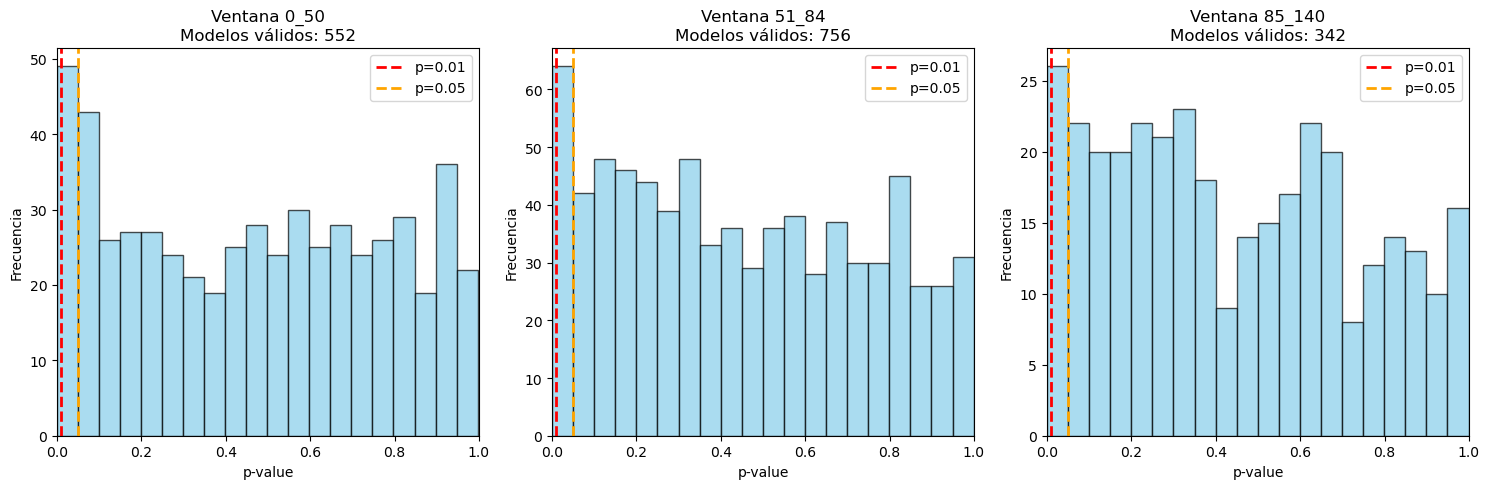


ESTADÍSTICAS DE DATOS FALTANTES (NaN)

Ventana 0_50:
  Promedio de NaN en especie causal: 3.4
  Promedio de NaN en especie respuesta: 3.4

Ventana 51_84:
  Promedio de NaN en especie causal: 3.9
  Promedio de NaN en especie respuesta: 3.9

Ventana 85_140:
  Promedio de NaN en especie causal: 5.1
  Promedio de NaN en especie respuesta: 5.1


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Definir las ventanas de tiempo
windows = {
    "0_50": (0, 50),
    "51_84": (51, 84),
    "85_140": (85, 140)
}

# Identificar las columnas de especies (desde Abies en adelante)
especies_cols = df_bas.columns[df_bas.columns.get_loc('Abies'):].tolist()

# Función para convertir ceros a NaN en columnas de especies
def convertir_ceros_a_nan(df, especies_cols):
    """
    Convierte los ceros en las columnas de especies a NaN
    porque representan "no muestra", no "ausencia"
    """
    df_mod = df.copy()
    for col in especies_cols:
        df_mod[col] = df_mod[col].replace(0, np.nan)
    return df_mod

# Función para verificar si una serie es válida para análisis
def es_serie_valida(serie, min_puntos=5, max_prop_nan=0.3):
    """
    Verifica si una serie temporal tiene suficientes datos no-NaN
    """
    # Eliminar NaN
    serie_clean = serie.dropna()
    
    # Verificar que tenemos suficientes puntos
    if len(serie_clean) < min_puntos:
        return False
    
    # Verificar proporción de NaN no sea demasiado alta
    prop_nan = serie.isna().sum() / len(serie)
    if prop_nan > max_prop_nan:
        return False
    
    # Verificar si hay variación (no todos los valores son iguales)
    if serie_clean.nunique() < 2:
        return False
    
    return True

# Función para interpolar valores NaN en una serie temporal
def interpolar_serie(serie, metodo='linear'):
    """
    Interpola valores NaN en una serie temporal
    """
    # Si hay NaN al principio o final, usar el valor válido más cercano
    serie_interp = serie.interpolate(method=metodo, limit_direction='both')
    
    # Si aún quedan NaN (por ejemplo, toda la serie es NaN), rellenar con 0
    # pero esto no debería pasar porque ya filtramos series válidas
    serie_interp = serie_interp.fillna(0)
    
    return serie_interp

# Función para calcular causalidad de Granger con manejo de NaN
def calcular_granger_con_nan(df_window_original, sp1, sp2):
    """
    Calcula la causalidad de Granger de sp1 a sp2
    con manejo especial de NaN (ceros originales)
    """
    # Extraer las series originales (con NaN)
    serie_x_original = df_window_original[sp1].copy()
    serie_y_original = df_window_original[sp2].copy()
    
    # Verificar que las series son válidas (suficientes datos no-NaN)
    if not es_serie_valida(serie_x_original) or not es_serie_valida(serie_y_original):
        return 1, 0, False, 0, 0
    
    # Registrar cuántos NaN había originalmente
    nan_x = serie_x_original.isna().sum()
    nan_y = serie_y_original.isna().sum()
    
    # Interpolar NaN para tener series completas
    serie_x = interpolar_serie(serie_x_original)
    serie_y = interpolar_serie(serie_y_original)
    
    # Invertir orden para que el tiempo fluya correctamente (de pasado a presente)
    array_x = serie_x.values[::-1]
    array_y = serie_y.values[::-1]
    
    # Crear dataframe para VAR
    data_tuple = pd.DataFrame({sp1: array_x, sp2: array_y})
    
    try:
        # Estandarizar las series
        scaler = StandardScaler()
        data_scaled = pd.DataFrame(
            scaler.fit_transform(data_tuple),
            columns=data_tuple.columns
        )
        
        # Ajustar modelo VAR
        model = VAR(data_scaled)
        
        # Seleccionar número de lags (máximo 3)
        max_lags = min(3, len(data_scaled)//3)
        if max_lags < 1:
            return 1, 0, False, nan_x, nan_y
        
        try:
            lag_selection = model.select_order(maxlags=max_lags)
            mejor_lag = lag_selection.aic
            if mejor_lag == 0 or np.isnan(mejor_lag):
                mejor_lag = 1
        except:
            mejor_lag = 1
        
        results = model.fit(maxlags=mejor_lag)
        
        # Test de causalidad
        causality = results.test_causality(caused=sp2, causing=[sp1], kind='f')
        p_value = causality.pvalue
        
        # Calcular coeficiente total
        coeficiente_total = 0
        for lag in range(mejor_lag):
            coef_idx = lag * len(results.names) + 0  # sp1 es el primero en nuestro dataframe
            coeficiente_total += results.coefs[lag][1][0]
        
        valido = True
        
    except Exception as e:
        p_value = 1
        coeficiente_total = 0
        valido = False
    
    return p_value, coeficiente_total, valido, nan_x, nan_y

# Procesar cada ventana
resultados_por_ventana = {}

print("="*70)
print("ANÁLISIS DE CAUSALIDAD DE GRANGER CON CEROS COMO NaN")
print("="*70)

for window_name, (start, end) in windows.items():
    print(f"\n{'='*50}")
    print(f"VENTANA: {window_name} (filas {start}-{end})")
    print(f"{'='*50}")
    
    # Filtrar datos para la ventana
    df_window_raw = df_bas.iloc[start:end+1].copy()
    
    # Convertir ceros a NaN en columnas de especies
    df_window = convertir_ceros_a_nan(df_window_raw, especies_cols)
    
    print(f"Dimensiones: {df_window.shape}")
    print(f"Rango temporal: {df_window['cal BP'].iloc[-1]} - {df_window['cal BP'].iloc[0]} cal BP")
    
    # Verificar que tenemos suficientes datos
    if len(df_window) < 5:
        print(f"⚠️ Ventana con muy pocos datos ({len(df_window)} filas)")
        continue
    
    # Identificar especies con suficientes datos
    especies_validas = []
    stats_especies = []
    
    for sp in especies_cols:
        serie = df_window[sp]
        n_nan = serie.isna().sum()
        prop_nan = n_nan / len(serie)
        n_unicos = serie.nunique()
        
        if es_serie_valida(serie):
            especies_validas.append(sp)
            stats_especies.append({
                'especie': sp,
                '%_NaN': f"{prop_nan*100:.1f}%",
                'n_unicos': n_unicos
            })
    
    print(f"\nEspecies con suficientes datos: {len(especies_validas)} de {len(especies_cols)}")
    
    # Mostrar algunas estadísticas de NaN
    if stats_especies:
        df_stats = pd.DataFrame(stats_especies).head(10)
        print("\nPrimeras 10 especies (con % de NaN):")
        print(df_stats.to_string(index=False))
    
    if len(especies_validas) < 3:
        print(f"⚠️ Muy pocas especies válidas (mínimo 3)")
        continue
    
    # Calcular causalidad para pares de especies válidas
    resultados = []
    pares_validos = 0
    pares_fallidos = 0
    total_nan_x = 0
    total_nan_y = 0
    
    n_especies = len(especies_validas)
    total_pares = n_especies * (n_especies - 1)
    
    print(f"\nAnalizando {total_pares} pares de especies...")
    
    for i, sp1 in enumerate(especies_validas):
        for j, sp2 in enumerate(especies_validas):
            if i != j:
                p_value, coef, valido, nan_x, nan_y = calcular_granger_con_nan(df_window, sp1, sp2)
                
                if valido:
                    pares_validos += 1
                    total_nan_x += nan_x
                    total_nan_y += nan_y
                else:
                    pares_fallidos += 1
                
                resultados.append({
                    'from': sp1,
                    'to': sp2,
                    'p_value': p_value,
                    'coefficient': coef,
                    'significant': p_value < 0.01,
                    'sign': 'positive' if coef > 0.01 else 'negative' if coef < -0.01 else 'neutral',
                    'modelo_valido': valido,
                    'nan_from': nan_x,
                    'nan_to': nan_y
                })
    
    # Convertir a DataFrame
    df_resultados = pd.DataFrame(resultados)
    resultados_por_ventana[window_name] = df_resultados
    
    # Estadísticas
    modelos_validos = df_resultados[df_resultados['modelo_valido']]
    significantes = df_resultados[df_resultados['significant']]
    
    n_links = len(significantes)
    n_positivos = len(significantes[significantes['sign'] == 'positive'])
    n_negativos = len(significantes[significantes['sign'] == 'negative'])
    
    print(f"\n{'='*30}")
    print(f"RESULTADOS VENTANA {window_name}")
    print(f"{'='*30}")
    print(f"Total pares analizados: {len(df_resultados)}")
    print(f"Modelos VAR exitosos: {len(modelos_validos)} ({len(modelos_validos)/len(df_resultados)*100:.1f}%)")
    print(f"Modelos fallidos: {len(df_resultados[~df_resultados['modelo_valido']])}")
    print(f"Links significativos (p < 0.01): {n_links}")
    
    if n_links > 0:
        print(f"  Positivos: {n_positivos} ({n_positivos/n_links*100:.1f}%)")
        print(f"  Negativos: {n_negativos} ({n_negativos/n_links*100:.1f}%)")
    
    if len(modelos_validos) > 0:
        print(f"\nDistribución de p-values (solo modelos válidos):")
        print(f"  p < 0.01: {len(modelos_validos[modelos_validos['p_value'] < 0.01])}")
        print(f"  p < 0.05: {len(modelos_validos[modelos_validos['p_value'] < 0.05])}")
        print(f"  p < 0.10: {len(modelos_validos[modelos_validos['p_value'] < 0.10])}")

# Visualización de resultados
if resultados_por_ventana:
    # Histograma de p-values (solo modelos válidos)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, (window_name, df_res) in enumerate(resultados_por_ventana.items()):
        ax = axes[idx]
        
        # Solo modelos válidos
        df_validos = df_res[df_res['modelo_valido']]
        
        if len(df_validos) > 0:
            ax.hist(df_validos['p_value'], bins=20, edgecolor='black', 
                   alpha=0.7, color='skyblue')
            ax.axvline(x=0.01, color='red', linestyle='--', label='p=0.01', linewidth=2)
            ax.axvline(x=0.05, color='orange', linestyle='--', label='p=0.05', linewidth=2)
            ax.set_xlabel('p-value')
            ax.set_ylabel('Frecuencia')
            ax.set_title(f'Ventana {window_name}\nModelos válidos: {len(df_validos)}')
            ax.legend()
            ax.set_xlim(0, 1)
        else:
            ax.text(0.5, 0.5, 'Sin modelos válidos', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Ventana {window_name}')
    
    plt.tight_layout()
    plt.savefig('histogramas_pvalues_con_nan.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Mostrar información sobre NaN
    print("\n" + "="*70)
    print("ESTADÍSTICAS DE DATOS FALTANTES (NaN)")
    print("="*70)
    
    for window_name, df_res in resultados_por_ventana.items():
        df_validos = df_res[df_res['modelo_valido']]
        if len(df_validos) > 0:
            avg_nan_from = df_validos['nan_from'].mean()
            avg_nan_to = df_validos['nan_to'].mean()
            print(f"\nVentana {window_name}:")
            print(f"  Promedio de NaN en especie causal: {avg_nan_from:.1f}")
            print(f"  Promedio de NaN en especie respuesta: {avg_nan_to:.1f}")
else:
    print("\n⚠️ No se obtuvieron resultados válidos en ninguna ventana")

ANÁLISIS DE CAUSALIDAD DE GRANGER CON CEROS COMO NaN

VENTANA: 0_50 (filas 0-50)
Dimensiones: (51, 87)
Rango temporal: 4553.2 - -56.9 cal BP

Especies con suficientes datos: 24 de 79

Primeras 10 especies (con % de NaN):
      especie %_NaN  n_unicos
        Abies 25.5%        12
        Pinus  0.0%        44
    Juniperus  0.0%        13
       Betula  0.0%        18
      Corylus  3.9%        14
        Fagus  3.9%        11
    Ericaceae  3.9%        10
      Poaceae  0.0%        21
    Artemisia  0.0%        27
Cichorioideae 13.7%        10

Analizando 552 pares de especies...

RESULTADOS VENTANA 0_50
Total pares analizados: 552
Modelos VAR exitosos: 552 (100.0%)
Modelos fallidos: 0
Links significativos (p < 0.01): 13
  Positivos: 10 (76.9%)
  Negativos: 3 (23.1%)
  Neutrales: 0 (0.0%)

Distribución de p-values (solo modelos válidos):
  p < 0.01: 13
  p < 0.05: 49
  p < 0.10: 92

VENTANA: 51_84 (filas 51-84)
Dimensiones: (34, 87)
Rango temporal: 7963.72 - 4661.7 cal BP

Especies co

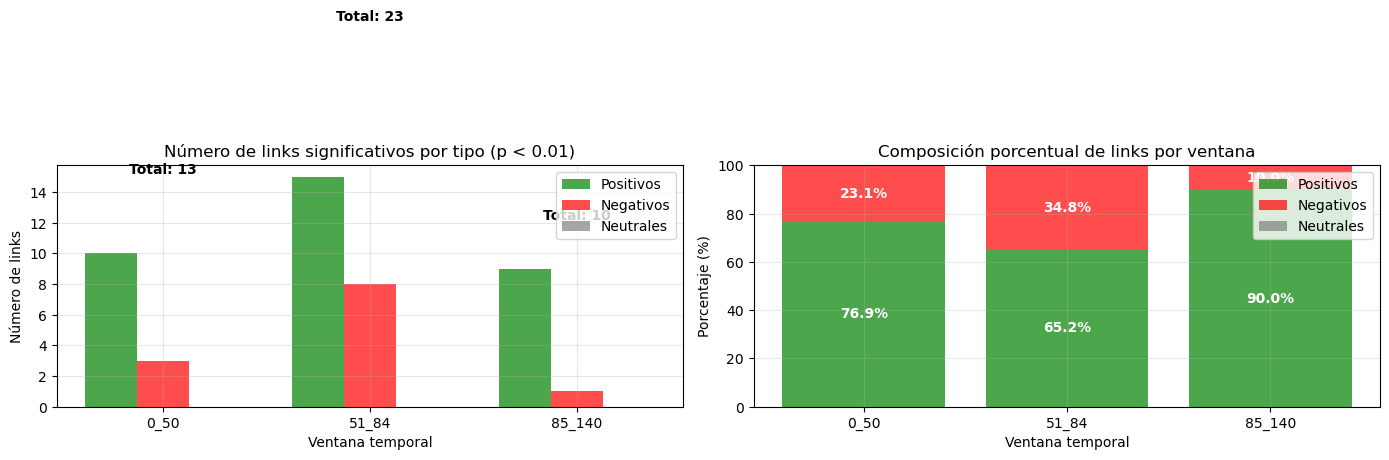

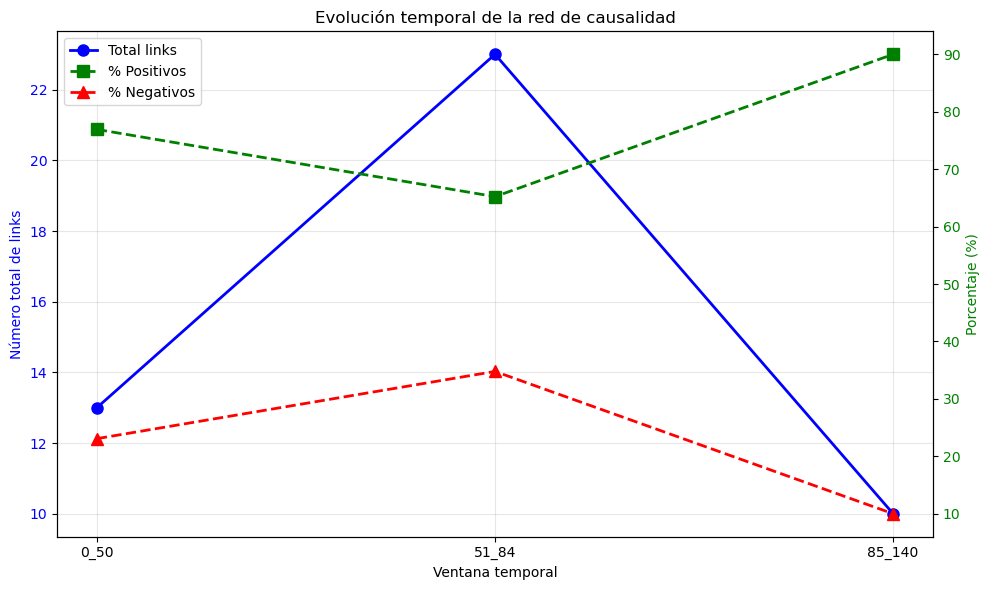


RESUMEN DE REDES POR VENTANA

         Links totales  Positivos  Negativos  Neutrales  % Positivos  % Negativos  % Neutrales  Densidad (%)
0_50               13         10          3          0         76.9         23.1          0.0         0.211
51_84              23         15          8          0         65.2         34.8          0.0         0.373
85_140             10          9          1          0         90.0         10.0          0.0         0.162

✅ Estadísticas guardadas en 'estadisticas_redes_granger.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Definir las ventanas de tiempo
windows = {
    "0_50": (0, 50),
    "51_84": (51, 84),
    "85_140": (85, 140)
}

# Identificar las columnas de especies (desde Abies en adelante)
especies_cols = df_bas.columns[df_bas.columns.get_loc('Abies'):].tolist()

# Función para convertir ceros a NaN en columnas de especies
def convertir_ceros_a_nan(df, especies_cols):
    """
    Convierte los ceros en las columnas de especies a NaN
    porque representan "no muestra", no "ausencia"
    """
    df_mod = df.copy()
    for col in especies_cols:
        df_mod[col] = df_mod[col].replace(0, np.nan)
    return df_mod

# Función para verificar si una serie es válida para análisis
def es_serie_valida(serie, min_puntos=5, max_prop_nan=0.3):
    """
    Verifica si una serie temporal tiene suficientes datos no-NaN
    """
    # Eliminar NaN
    serie_clean = serie.dropna()
    
    # Verificar que tenemos suficientes puntos
    if len(serie_clean) < min_puntos:
        return False
    
    # Verificar proporción de NaN no sea demasiado alta
    prop_nan = serie.isna().sum() / len(serie)
    if prop_nan > max_prop_nan:
        return False
    
    # Verificar si hay variación (no todos los valores son iguales)
    if serie_clean.nunique() < 2:
        return False
    
    return True

# Función para interpolar valores NaN en una serie temporal
def interpolar_serie(serie, metodo='linear'):
    """
    Interpola valores NaN en una serie temporal
    """
    # Si hay NaN al principio o final, usar el valor válido más cercano
    serie_interp = serie.interpolate(method=metodo, limit_direction='both')
    
    # Si aún quedan NaN (por ejemplo, toda la serie es NaN), rellenar con 0
    # pero esto no debería pasar porque ya filtramos series válidas
    serie_interp = serie_interp.fillna(0)
    
    return serie_interp

# Función para calcular causalidad de Granger con manejo de NaN
def calcular_granger_con_nan(df_window_original, sp1, sp2):
    """
    Calcula la causalidad de Granger de sp1 a sp2
    con manejo especial de NaN (ceros originales)
    """
    # Extraer las series originales (con NaN)
    serie_x_original = df_window_original[sp1].copy()
    serie_y_original = df_window_original[sp2].copy()
    
    # Verificar que las series son válidas (suficientes datos no-NaN)
    if not es_serie_valida(serie_x_original) or not es_serie_valida(serie_y_original):
        return 1, 0, False, 0, 0
    
    # Registrar cuántos NaN había originalmente
    nan_x = serie_x_original.isna().sum()
    nan_y = serie_y_original.isna().sum()
    
    # Interpolar NaN para tener series completas
    serie_x = interpolar_serie(serie_x_original)
    serie_y = interpolar_serie(serie_y_original)
    
    # INVERTIR orden para que el tiempo fluya correctamente (de pasado a presente)
    # Los datos originales están de más reciente a más antiguo
    array_x = serie_x.values[::-1]  # Invertir: ahora de más antiguo a más reciente
    array_y = serie_y.values[::-1]  # Invertir: ahora de más antiguo a más reciente
    
    # Crear dataframe para VAR
    data_tuple = pd.DataFrame({sp1: array_x, sp2: array_y})
    
    try:
        # Estandarizar las series
        scaler = StandardScaler()
        data_scaled = pd.DataFrame(
            scaler.fit_transform(data_tuple),
            columns=data_tuple.columns
        )
        
        # Ajustar modelo VAR
        model = VAR(data_scaled)
        
        # Seleccionar número de lags (máximo 3)
        max_lags = min(3, len(data_scaled)//3)
        if max_lags < 1:
            return 1, 0, False, nan_x, nan_y
        
        try:
            lag_selection = model.select_order(maxlags=max_lags)
            mejor_lag = lag_selection.aic
            if mejor_lag == 0 or np.isnan(mejor_lag):
                mejor_lag = 1
        except:
            mejor_lag = 1
        
        results = model.fit(maxlags=mejor_lag)
        
        # Test de causalidad
        causality = results.test_causality(caused=sp2, causing=[sp1], kind='f')
        p_value = causality.pvalue
        
        # Calcular coeficiente total (suma de todos los lags)
        coeficiente_total = 0
        for lag in range(mejor_lag):
            # En la ecuación de sp2 (índice 1), el coeficiente de sp1 (índice 0)
            coeficiente_total += results.coefs[lag][1][0]
        
        valido = True
        
    except Exception as e:
        p_value = 1
        coeficiente_total = 0
        valido = False
    
    return p_value, coeficiente_total, valido, nan_x, nan_y

# Procesar cada ventana
resultados_por_ventana = {}

print("="*70)
print("ANÁLISIS DE CAUSALIDAD DE GRANGER CON CEROS COMO NaN")
print("="*70)

for window_name, (start, end) in windows.items():
    print(f"\n{'='*50}")
    print(f"VENTANA: {window_name} (filas {start}-{end})")
    print(f"{'='*50}")
    
    # Filtrar datos para la ventana
    df_window_raw = df_bas.iloc[start:end+1].copy()
    
    # Convertir ceros a NaN en columnas de especies
    df_window = convertir_ceros_a_nan(df_window_raw, especies_cols)
    
    print(f"Dimensiones: {df_window.shape}")
    print(f"Rango temporal: {df_window['cal BP'].iloc[-1]} - {df_window['cal BP'].iloc[0]} cal BP")
    
    # Verificar que tenemos suficientes datos
    if len(df_window) < 5:
        print(f"⚠️ Ventana con muy pocos datos ({len(df_window)} filas)")
        continue
    
    # Identificar especies con suficientes datos
    especies_validas = []
    stats_especies = []
    
    for sp in especies_cols:
        serie = df_window[sp]
        n_nan = serie.isna().sum()
        prop_nan = n_nan / len(serie)
        n_unicos = serie.nunique()
        
        if es_serie_valida(serie):
            especies_validas.append(sp)
            stats_especies.append({
                'especie': sp,
                '%_NaN': f"{prop_nan*100:.1f}%",
                'n_unicos': n_unicos
            })
    
    print(f"\nEspecies con suficientes datos: {len(especies_validas)} de {len(especies_cols)}")
    
    # Mostrar algunas estadísticas de NaN
    if stats_especies:
        df_stats = pd.DataFrame(stats_especies).head(10)
        print("\nPrimeras 10 especies (con % de NaN):")
        print(df_stats.to_string(index=False))
    
    if len(especies_validas) < 3:
        print(f"⚠️ Muy pocas especies válidas (mínimo 3)")
        continue
    
    # Calcular causalidad para pares de especies válidas
    resultados = []
    pares_validos = 0
    pares_fallidos = 0
    total_nan_x = 0
    total_nan_y = 0
    
    n_especies = len(especies_validas)
    total_pares = n_especies * (n_especies - 1)
    
    print(f"\nAnalizando {total_pares} pares de especies...")
    
    for i, sp1 in enumerate(especies_validas):
        for j, sp2 in enumerate(especies_validas):
            if i != j:
                p_value, coef, valido, nan_x, nan_y = calcular_granger_con_nan(df_window, sp1, sp2)
                
                if valido:
                    pares_validos += 1
                    total_nan_x += nan_x
                    total_nan_y += nan_y
                else:
                    pares_fallidos += 1
                
                resultados.append({
                    'from': sp1,
                    'to': sp2,
                    'p_value': p_value,
                    'coefficient': coef,
                    'significant': p_value < 0.01,
                    'sign': 'positive' if coef > 0.01 else 'negative' if coef < -0.01 else 'neutral',
                    'modelo_valido': valido,
                    'nan_from': nan_x,
                    'nan_to': nan_y
                })
    
    # Convertir a DataFrame
    df_resultados = pd.DataFrame(resultados)
    resultados_por_ventana[window_name] = df_resultados
    
    # Estadísticas
    modelos_validos = df_resultados[df_resultados['modelo_valido']]
    significantes = df_resultados[df_resultados['significant']]
    
    n_links = len(significantes)
    n_positivos = len(significantes[significantes['sign'] == 'positive'])
    n_negativos = len(significantes[significantes['sign'] == 'negative'])
    n_neutrales = len(significantes[significantes['sign'] == 'neutral'])
    
    print(f"\n{'='*30}")
    print(f"RESULTADOS VENTANA {window_name}")
    print(f"{'='*30}")
    print(f"Total pares analizados: {len(df_resultados)}")
    print(f"Modelos VAR exitosos: {len(modelos_validos)} ({len(modelos_validos)/len(df_resultados)*100:.1f}%)")
    print(f"Modelos fallidos: {len(df_resultados[~df_resultados['modelo_valido']])}")
    print(f"Links significativos (p < 0.01): {n_links}")
    
    if n_links > 0:
        print(f"  Positivos: {n_positivos} ({n_positivos/n_links*100:.1f}%)")
        print(f"  Negativos: {n_negativos} ({n_negativos/n_links*100:.1f}%)")
        print(f"  Neutrales: {n_neutrales} ({n_neutrales/n_links*100:.1f}%)")
    
    if len(modelos_validos) > 0:
        print(f"\nDistribución de p-values (solo modelos válidos):")
        print(f"  p < 0.01: {len(modelos_validos[modelos_validos['p_value'] < 0.01])}")
        print(f"  p < 0.05: {len(modelos_validos[modelos_validos['p_value'] < 0.05])}")
        print(f"  p < 0.10: {len(modelos_validos[modelos_validos['p_value'] < 0.10])}")

# ============================================
# PARTE PRINCIPAL: CÁLCULO DE PORCENTAJES DE LINKS
# ============================================

print("\n" + "="*70)
print("ANÁLISIS DE REDES: LINKS TOTALES, POSITIVOS Y NEGATIVOS")
print("="*70)

# Diccionario para almacenar estadísticas de redes
estadisticas_redes = {}

for window_name, df_res in resultados_por_ventana.items():
    # Filtrar solo relaciones significativas (p < 0.01)
    df_sig = df_res[df_res['significant']].copy()
    
    # Calcular estadísticas
    total_links = len(df_sig)
    links_positivos = len(df_sig[df_sig['sign'] == 'positive'])
    links_negativos = len(df_sig[df_sig['sign'] == 'negative'])
    links_neutrales = len(df_sig[df_sig['sign'] == 'neutral'])
    
    # Calcular porcentajes
    pct_positivos = (links_positivos / total_links * 100) if total_links > 0 else 0
    pct_negativos = (links_negativos / total_links * 100) if total_links > 0 else 0
    pct_neutrales = (links_neutrales / total_links * 100) if total_links > 0 else 0
    
    # Guardar estadísticas
    estadisticas_redes[window_name] = {
        'total_links': total_links,
        'links_positivos': links_positivos,
        'links_negativos': links_negativos,
        'links_neutrales': links_neutrales,
        '%_positivos': pct_positivos,
        '%_negativos': pct_negativos,
        '%_neutrales': pct_neutrales,
        'densidad_red': total_links / (len(especies_cols) * (len(especies_cols) - 1)) if len(especies_cols) > 1 else 0
    }

# Crear DataFrame con estadísticas
df_estadisticas = pd.DataFrame(estadisticas_redes).T
print("\n" + df_estadisticas.to_string())

# ============================================
# VISUALIZACIÓN 1: Gráfico de barras comparativo
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Número de links por tipo
ax1 = axes[0]
ventanas = list(estadisticas_redes.keys())
x = np.arange(len(ventanas))
width = 0.25

positivos = [estadisticas_redes[w]['links_positivos'] for w in ventanas]
negativos = [estadisticas_redes[w]['links_negativos'] for w in ventanas]
neutrales = [estadisticas_redes[w]['links_neutrales'] for w in ventanas]

ax1.bar(x - width, positivos, width, label='Positivos', color='green', alpha=0.7)
ax1.bar(x, negativos, width, label='Negativos', color='red', alpha=0.7)
ax1.bar(x + width, neutrales, width, label='Neutrales', color='gray', alpha=0.7)

ax1.set_xlabel('Ventana temporal')
ax1.set_ylabel('Número de links')
ax1.set_title('Número de links significativos por tipo (p < 0.01)')
ax1.set_xticks(x)
ax1.set_xticklabels(ventanas)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Añadir etiquetas con el total
for i, (p, n, neu) in enumerate(zip(positivos, negativos, neutrales)):
    total = p + n + neu
    ax1.text(i, total + 2, f'Total: {total}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Porcentajes
ax2 = axes[1]
pct_positivos = [estadisticas_redes[w]['%_positivos'] for w in ventanas]
pct_negativos = [estadisticas_redes[w]['%_negativos'] for w in ventanas]
pct_neutrales = [estadisticas_redes[w]['%_neutrales'] for w in ventanas]

ax2.bar(x, pct_positivos, bottom=0, label='Positivos', color='green', alpha=0.7)
ax2.bar(x, pct_negativos, bottom=pct_positivos, label='Negativos', color='red', alpha=0.7)
ax2.bar(x, pct_neutrales, bottom=np.array(pct_positivos) + np.array(pct_negativos), 
        label='Neutrales', color='gray', alpha=0.7)

ax2.set_xlabel('Ventana temporal')
ax2.set_ylabel('Porcentaje (%)')
ax2.set_title('Composición porcentual de links por ventana')
ax2.set_xticks(x)
ax2.set_xticklabels(ventanas)
ax2.legend(loc='upper right')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)

# Añadir etiquetas de porcentaje
for i, (p, n, neu) in enumerate(zip(pct_positivos, pct_negativos, pct_neutrales)):
    ax2.text(i, p/2, f'{p:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    ax2.text(i, p + n/2, f'{n:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    if neu > 0:
        ax2.text(i, p + n + neu/2, f'{neu:.1f}%', ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.savefig('comparacion_links_por_ventana.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# VISUALIZACIÓN 2: Diagrama de evolución temporal
# ============================================

fig, ax = plt.subplots(figsize=(10, 6))

# Preparar datos para línea de evolución
totales = [estadisticas_redes[w]['total_links'] for w in ventanas]
pct_pos = [estadisticas_redes[w]['%_positivos'] for w in ventanas]
pct_neg = [estadisticas_redes[w]['%_negativos'] for w in ventanas]

# Escala secundaria para porcentajes
ax2 = ax.twinx()

# Plotear líneas
line1, = ax.plot(ventanas, totales, 'b-o', linewidth=2, markersize=8, label='Total links')
line2, = ax2.plot(ventanas, pct_pos, 'g--s', linewidth=2, markersize=8, label='% Positivos')
line3, = ax2.plot(ventanas, pct_neg, 'r--^', linewidth=2, markersize=8, label='% Negativos')

ax.set_xlabel('Ventana temporal')
ax.set_ylabel('Número total de links', color='b')
ax2.set_ylabel('Porcentaje (%)', color='g')
ax.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='g')

# Añadir leyenda combinada
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left')

ax.set_title('Evolución temporal de la red de causalidad')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evolucion_temporal_red.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# VISUALIZACIÓN 3: Tabla resumen formateada
# ============================================

print("\n" + "="*70)
print("RESUMEN DE REDES POR VENTANA")
print("="*70)

# Formatear para mejor visualización
df_resumen = df_estadisticas.copy()
df_resumen['total_links'] = df_resumen['total_links'].astype(int)
df_resumen['links_positivos'] = df_resumen['links_positivos'].astype(int)
df_resumen['links_negativos'] = df_resumen['links_negativos'].astype(int)
df_resumen['links_neutrales'] = df_resumen['links_neutrales'].astype(int)
df_resumen['%_positivos'] = df_resumen['%_positivos'].round(1)
df_resumen['%_negativos'] = df_resumen['%_negativos'].round(1)
df_resumen['%_neutrales'] = df_resumen['%_neutrales'].round(1)
df_resumen['densidad_red'] = (df_resumen['densidad_red'] * 100).round(3)

# Renombrar columnas para mejor presentación
df_resumen.columns = ['Links totales', 'Positivos', 'Negativos', 'Neutrales', 
                      '% Positivos', '% Negativos', '% Neutrales', 'Densidad (%)']

print("\n", df_resumen.to_string())

# Guardar resultados
df_resumen.to_csv('estadisticas_redes_granger.csv')
print("\n✅ Estadísticas guardadas en 'estadisticas_redes_granger.csv'")

# ============================================
# VISUALIZACIÓN 4: Redes dirigidas (opcional)
# ============================================

# # Preguntar si quiere ver las redes
# ver_redes = input("\n¿Quieres visualizar las redes dirigidas? (s/n): ").lower()

# if ver_redes == 's':
#     fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
#     for idx, (window_name, df_res) in enumerate(resultados_por_ventana.items()):
#         # Filtrar solo relaciones significativas
#         df_sig = df_res[df_res['significant']]
        
#         # Crear grafo dirigido
#         G = nx.DiGraph()
        
#         # Añadir nodos (todas las especies)
#         G.add_nodes_from(especies_cols)
        
#         # Añadir aristas con atributos
#         for _, row in df_sig.iterrows():
#             G.add_edge(row['from'], row['to'], 
#                       weight=abs(row['coefficient']),
#                       sign=row['sign'],
#                       p_value=row['p_value'])
        
#         # Visualizar red
#         ax = axes[idx]
        
#         if len(df_sig) > 0:
#             # Posiciones de los nodos (usar circular para mejor visualización)
#             pos = nx.circular_layout(G)
            
#             # Dibujar nodos
#             nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
#                                   node_size=300, ax=ax)
            
#             # Dibujar aristas según signo
#             edges_pos = [(u, v) for (u, v, d) in G.edges(data=True) if d['sign'] == 'positive']
#             edges_neg = [(u, v) for (u, v, d) in G.edges(data=True) if d['sign'] == 'negative']
#             edges_neu = [(u, v) for (u, v, d) in G.edges(data=True) if d['sign'] == 'neutral']
            
#             if edges_pos:
#                 nx.draw_networkx_edges(G, pos, edgelist=edges_pos, 
#                                       edge_color='green', width=1.5, 
#                                       alpha=0.6, arrowstyle='->', 
#                                       arrowsize=15, ax=ax)
            
#             if edges_neg:
#                 nx.draw_networkx_edges(G, pos, edgelist=edges_neg, 
#                                       edge_color='red', width=1.5, 
#                                       alpha=0.6, arrowstyle='->', 
#                                       arrowsize=15, ax=ax)
            
#             if edges_neu:
#                 nx.draw_networkx_edges(G, pos, edgelist=edges_neu, 
#                                       edge_color='gray', width=1.5, 
#                                       alpha=0.6, arrowstyle='->', 
#                                       arrowsize=15, ax=ax)
            
#             # Etiquetas de nodos (solo algunas para no saturar)
#             labels = {node: node[:10] + '...' if len(node) > 10 else node 
#                      for node in G.nodes()}
#             nx.draw_networkx_labels(G, pos, labels, font_size=6, ax=ax)
        
#         # Configurar el gráfico
#         stats = estadisticas_redes[window_name]
#         ax.set_title(f'{window_name}\nLinks: {stats["total_links"]} '
#                     f'(P:{stats["%_positivos"]:.0f}%, N:{stats["%_negativos"]:.0f}%)')
#         ax.axis('off')
    
#     plt.tight_layout()
#     plt.savefig('redes_causalidad_3_ventanas.png', dpi=300, bbox_inches='tight')
#     plt.show()

Total especies: 79
Umbral p-value: 0.05
Mínimo puntos por serie: 3

Procesando 0_50...
  Especies válidas: 67
  Pares analizados: 4422
  Links significativos (p < 0.05): 333
    Positivos: 231 (69.4%)
    Negativos: 102 (30.6%)

Procesando 51_84...
  Especies válidas: 63
  Pares analizados: 3906
  Links significativos (p < 0.05): 263
    Positivos: 166 (63.1%)
    Negativos: 97 (36.9%)

Procesando 85_140...
  Especies válidas: 59
  Pares analizados: 3422
  Links significativos (p < 0.05): 350
    Positivos: 245 (70.0%)
    Negativos: 105 (30.0%)


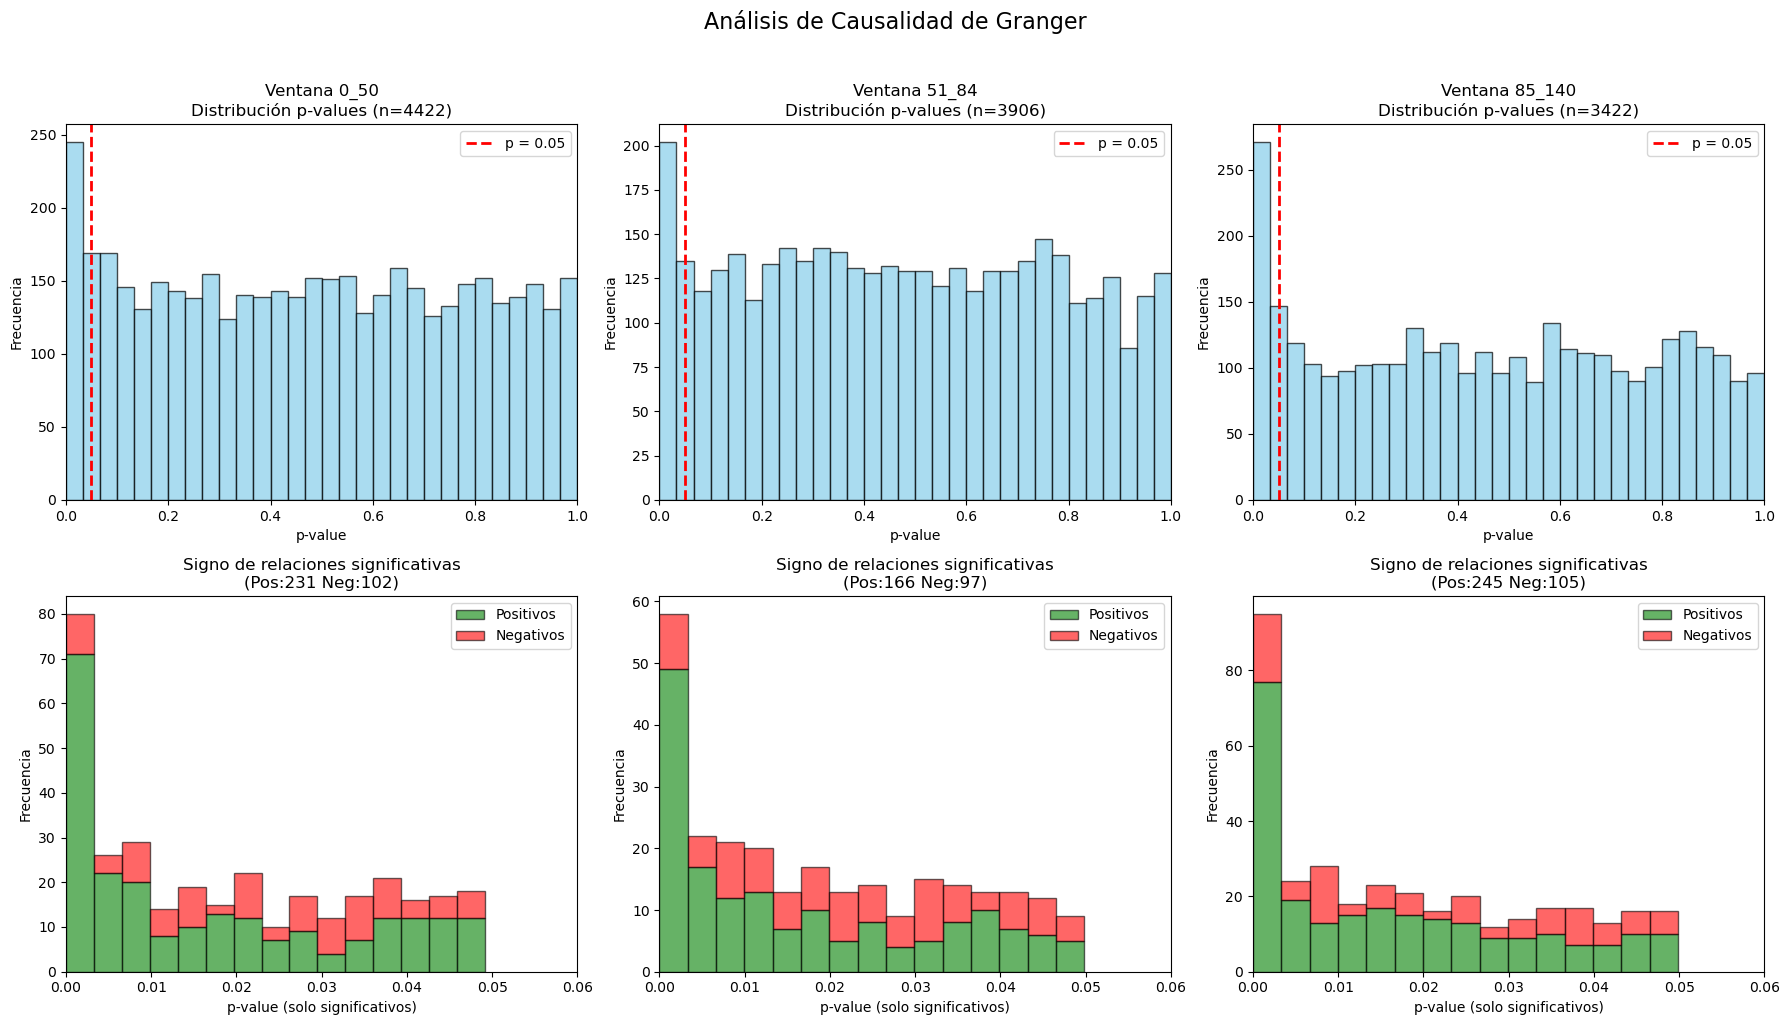


PORCENTAJES DE LINKS POR VENTANA

 Ventana  Total pares  Links totales % del total  Positivos % positivos  Negativos % negativos
   0_50         4422            333       7.53%        231       69.4%        102       30.6%
  51_84         3906            263       6.73%        166       63.1%         97       36.9%
 85_140         3422            350      10.23%        245       70.0%        105       30.0%


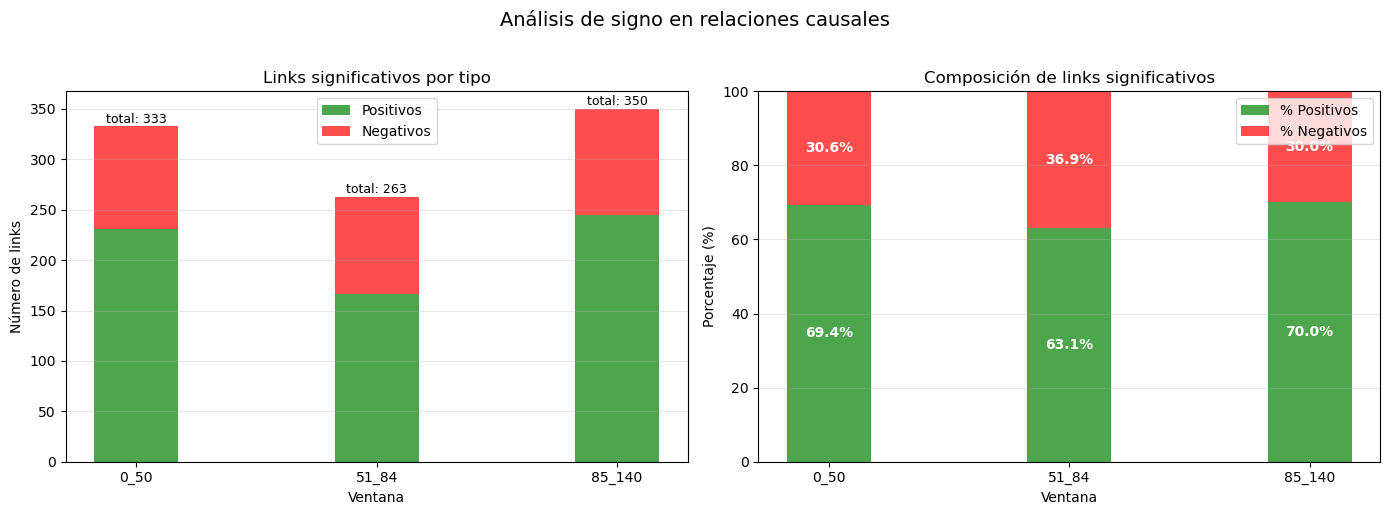


RESUMEN FINAL - PORCENTAJES COMPLETOS

0_50:
  Total pares analizados: 4422
  Links significativos: 333 (7.53% del total)
    Positivos: 231 (69.4% de los significativos)
    Negativos: 102 (30.6% de los significativos)
    Mejor positivo: Ribes -> Papaver (p=0.0000)
    Mejor negativo: Buxus -> Boraginaceae (p=0.0006)

51_84:
  Total pares analizados: 3906
  Links significativos: 263 (6.73% del total)
    Positivos: 166 (63.1% de los significativos)
    Negativos: 97 (36.9% de los significativos)
    Mejor positivo: Cistaceae -> Convolvulaceae (p=0.0000)
    Mejor negativo: Ulmus -> Centaurea (p=0.0001)

85_140:
  Total pares analizados: 3422
  Links significativos: 350 (10.23% del total)
    Positivos: 245 (70.0% de los significativos)
    Negativos: 105 (30.0% de los significativos)
    Mejor positivo: Ephedra fragilis -> Iridaceae (p=0.0000)
    Mejor negativo: Myrtus -> Plantago (p=0.0000)

✅ Análisis completado - Incluye links positivos y negativos


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Definir las ventanas de tiempo
windows = {
    "0_50": (0, 50),
    "51_84": (51, 84),
    "85_140": (85, 140)
}

# Identificar todas las columnas de especies
especies_cols = df_bas.columns[df_bas.columns.get_loc('Abies'):].tolist()
print(f"Total especies: {len(especies_cols)}")

# ============================================
# PARÁMETROS
# ============================================
UMBRAL_P_VALUE = 0.05
MIN_PUNTOS_SERIE = 3
print(f"Umbral p-value: {UMBRAL_P_VALUE}")
print(f"Mínimo puntos por serie: {MIN_PUNTOS_SERIE}")
print("="*50)

# Función para convertir ceros a NaN
def convertir_ceros_a_nan(df):
    df_mod = df.copy()
    for col in especies_cols:
        df_mod[col] = df_mod[col].replace(0, np.nan)
    return df_mod

# Función de validación simple
def es_valida(serie):
    return serie.count() >= MIN_PUNTOS_SERIE

# Función para calcular Granger (devuelve p-value y coeficiente)
def calcular_granger(df_window, sp1, sp2):
    try:
        # Obtener series
        serie_x = df_window[sp1].copy()
        serie_y = df_window[sp2].copy()
        
        # Verificar validez mínima
        if serie_x.count() < MIN_PUNTOS_SERIE or serie_y.count() < MIN_PUNTOS_SERIE:
            return None, None
        
        # Interpolar
        serie_x = serie_x.interpolate(limit_direction='both').fillna(serie_x.mean()).fillna(0)
        serie_y = serie_y.interpolate(limit_direction='both').fillna(serie_y.mean()).fillna(0)
        
        # Invertir (crítico para el orden temporal)
        array_x = serie_x.values[::-1]
        array_y = serie_y.values[::-1]
        
        # Añadir ruido mínimo
        array_x = array_x + np.random.normal(0, 1e-6, len(array_x))
        array_y = array_y + np.random.normal(0, 1e-6, len(array_y))
        
        # VAR
        data = pd.DataFrame({sp1: array_x, sp2: array_y})
        scaler = StandardScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
        
        model = VAR(data_scaled)
        results = model.fit(maxlags=1)
        
        # Test de causalidad
        causality = results.test_causality(caused=sp2, causing=[sp1], kind='f')
        p_value = causality.pvalue
        
        # Coeficiente (signo de la relación)
        coeficiente = results.coefs[0][1][0]
        
        return p_value, coeficiente
        
    except:
        return None, None

# Procesar cada ventana
resultados = {}

for window_name, (start, end) in windows.items():
    print(f"\nProcesando {window_name}...")
    
    # Preparar datos
    df_window = df_bas.iloc[start:end+1].copy()
    df_window = convertir_ceros_a_nan(df_window)
    
    # Identificar especies válidas
    especies_validas = [sp for sp in especies_cols if es_valida(df_window[sp])]
    print(f"  Especies válidas: {len(especies_validas)}")
    
    if len(especies_validas) < 2:
        print(f"  ⚠️ No hay suficientes especies")
        resultados[window_name] = pd.DataFrame()
        continue
    
    # Calcular todos los pares
    datos_pares = []
    pares_validos = 0
    
    n_especies = len(especies_validas)
    total_pares = n_especies * (n_especies - 1)
    
    for i, sp1 in enumerate(especies_validas):
        for j, sp2 in enumerate(especies_validas):
            if i != j:
                p_value, coeficiente = calcular_granger(df_window, sp1, sp2)
                if p_value is not None and coeficiente is not None:
                    datos_pares.append({
                        'from': sp1,
                        'to': sp2,
                        'p_value': p_value,
                        'coeficiente': coeficiente,
                        'signo': 'positivo' if coeficiente > 0 else 'negativo'
                    })
                    pares_validos += 1
    
    # Crear DataFrame con resultados
    if datos_pares:
        df_res = pd.DataFrame(datos_pares)
        resultados[window_name] = df_res
        
        # Calcular estadísticas
        n_total = len(df_res)
        significativos = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        n_sig = len(significativos)
        
        if n_sig > 0:
            n_pos = len(significativos[significativos['signo'] == 'positivo'])
            n_neg = len(significativos[significativos['signo'] == 'negativo'])
            pct_pos = (n_pos / n_sig * 100)
            pct_neg = (n_neg / n_sig * 100)
        else:
            n_pos = n_neg = 0
            pct_pos = pct_neg = 0
        
        print(f"  Pares analizados: {n_total}")
        print(f"  Links significativos (p < {UMBRAL_P_VALUE}): {n_sig}")
        print(f"    Positivos: {n_pos} ({pct_pos:.1f}%)")
        print(f"    Negativos: {n_neg} ({pct_neg:.1f}%)")
    else:
        print(f"  ⚠️ No se obtuvieron resultados")
        resultados[window_name] = pd.DataFrame()

# ============================================
# OUTPUT 1: HISTOGRAMAS
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (window_name, df_res) in enumerate(resultados.items()):
    if len(df_res) == 0:
        continue
        
    # Histograma de p-values (fila superior)
    ax1 = axes[0, idx]
    ax1.hist(df_res['p_value'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax1.axvline(x=UMBRAL_P_VALUE, color='red', linestyle='--', linewidth=2, 
                label=f'p = {UMBRAL_P_VALUE}')
    ax1.set_xlabel('p-value')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title(f'Ventana {window_name}\nDistribución p-values (n={len(df_res)})')
    ax1.legend()
    ax1.set_xlim(0, 1)
    
    # Separar por signo (fila inferior)
    ax2 = axes[1, idx]
    
    # Filtrar significativos
    sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
    
    if len(sig) > 0:
        pos = sig[sig['signo'] == 'positivo']['p_value']
        neg = sig[sig['signo'] == 'negativo']['p_value']
        
        ax2.hist([pos, neg], bins=15, edgecolor='black', 
                label=['Positivos', 'Negativos'], 
                color=['green', 'red'], alpha=0.6, stacked=True)
        ax2.set_xlabel('p-value (solo significativos)')
        ax2.set_ylabel('Frecuencia')
        ax2.set_title(f'Signo de relaciones significativas\n(Pos:{len(pos)} Neg:{len(neg)})')
        ax2.legend()
        ax2.set_xlim(0, UMBRAL_P_VALUE*1.2)
    else:
        ax2.text(0.5, 0.5, 'Sin relaciones significativas', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Sin datos significativos')

plt.suptitle('Análisis de Causalidad de Granger', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('histogramas_completos.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# OUTPUT 2: PORCENTAJES DE LINKS (TOTALES, POSITIVOS Y NEGATIVOS)
# ============================================
print("\n" + "="*70)
print("PORCENTAJES DE LINKS POR VENTANA")
print("="*70)

# Crear DataFrame con estadísticas
stats_list = []

for window_name, df_res in resultados.items():
    if len(df_res) > 0:
        n_total = len(df_res)
        sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        n_sig = len(sig)
        pct_sig = (n_sig / n_total * 100) if n_total > 0 else 0
        
        if n_sig > 0:
            n_pos = len(sig[sig['signo'] == 'positivo'])
            n_neg = len(sig[sig['signo'] == 'negativo'])
            pct_pos = (n_pos / n_sig * 100)
            pct_neg = (n_neg / n_sig * 100)
        else:
            n_pos = n_neg = 0
            pct_pos = pct_neg = 0
        
        stats_list.append({
            'Ventana': window_name,
            'Total pares': n_total,
            'Links totales': n_sig,
            '% del total': f"{pct_sig:.2f}%",
            'Positivos': n_pos,
            '% positivos': f"{pct_pos:.1f}%",
            'Negativos': n_neg,
            '% negativos': f"{pct_neg:.1f}%"
        })
    else:
        stats_list.append({
            'Ventana': window_name,
            'Total pares': 0,
            'Links totales': 0,
            '% del total': "0.00%",
            'Positivos': 0,
            '% positivos': "0.0%",
            'Negativos': 0,
            '% negativos': "0.0%"
        })

# Mostrar tabla
df_stats = pd.DataFrame(stats_list)
print("\n", df_stats.to_string(index=False))

# Gráfico de barras apiladas (porcentajes)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Número de links
ventanas = [s['Ventana'] for s in stats_list]
positivos = [s['Positivos'] for s in stats_list]
negativos = [s['Negativos'] for s in stats_list]
totales = [s['Links totales'] for s in stats_list]

x = np.arange(len(ventanas))
width = 0.35

ax1.bar(x, positivos, width, label='Positivos', color='green', alpha=0.7)
ax1.bar(x, negativos, width, bottom=positivos, label='Negativos', color='red', alpha=0.7)
ax1.set_xlabel('Ventana')
ax1.set_ylabel('Número de links')
ax1.set_title('Links significativos por tipo')
ax1.set_xticks(x)
ax1.set_xticklabels(ventanas)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Añadir etiquetas con totales
for i, total in enumerate(totales):
    ax1.text(i, total + 0.5, f'total: {total}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Porcentajes
pct_pos = [float(s['% positivos'].replace('%', '')) for s in stats_list]
pct_neg = [float(s['% negativos'].replace('%', '')) for s in stats_list]

ax2.bar(x, pct_pos, width, label='% Positivos', color='green', alpha=0.7)
ax2.bar(x, pct_neg, width, bottom=pct_pos, label='% Negativos', color='red', alpha=0.7)
ax2.set_xlabel('Ventana')
ax2.set_ylabel('Porcentaje (%)')
ax2.set_title('Composición de links significativos')
ax2.set_xticks(x)
ax2.set_xticklabels(ventanas)
ax2.legend()
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3, axis='y')

# Añadir etiquetas de porcentaje
for i, (p, n) in enumerate(zip(pct_pos, pct_neg)):
    if p > 0:
        ax2.text(i, p/2, f'{p:.1f}%', ha='center', va='center', color='white', fontweight='bold')
    if n > 0:
        ax2.text(i, p + n/2, f'{n:.1f}%', ha='center', va='center', color='white', fontweight='bold')

plt.suptitle('Análisis de signo en relaciones causales', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('porcentajes_positivos_negativos.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# RESUMEN FINAL CON TODOS LOS PORCENTAJES
# ============================================
print("\n" + "="*70)
print("RESUMEN FINAL - PORCENTAJES COMPLETOS")
print("="*70)

for window_name, df_res in resultados.items():
    if len(df_res) > 0:
        sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        n_total = len(df_res)
        n_sig = len(sig)
        
        print(f"\n{window_name}:")
        print(f"  Total pares analizados: {n_total}")
        print(f"  Links significativos: {n_sig} ({n_sig/n_total*100:.2f}% del total)")
        
        if n_sig > 0:
            n_pos = len(sig[sig['signo'] == 'positivo'])
            n_neg = len(sig[sig['signo'] == 'negativo'])
            print(f"    Positivos: {n_pos} ({n_pos/n_sig*100:.1f}% de los significativos)")
            print(f"    Negativos: {n_neg} ({n_neg/n_sig*100:.1f}% de los significativos)")
            
            # Mostrar ejemplo del link más significativo de cada tipo
            if n_pos > 0:
                top_pos = sig[sig['signo'] == 'positivo'].nsmallest(1, 'p_value').iloc[0]
                print(f"    Mejor positivo: {top_pos['from']} -> {top_pos['to']} (p={top_pos['p_value']:.4f})")
            if n_neg > 0:
                top_neg = sig[sig['signo'] == 'negativo'].nsmallest(1, 'p_value').iloc[0]
                print(f"    Mejor negativo: {top_neg['from']} -> {top_neg['to']} (p={top_neg['p_value']:.4f})")
    else:
        print(f"\n{window_name}: Sin resultados")

print("\n" + "="*70)
print("✅ Análisis completado - Incluye links positivos y negativos")
print("="*70)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')

# ============================================
# FUNCIÓN PARA RECONSTRUIR SERIE CON GAM
# ============================================

def reconstruir_con_gam(serie_original, tiempo, n_splines=10, lambda_=0.6):
    """
    Reconstruye una serie temporal usando GAM (splines)
    
    Parámetros:
    - serie_original: serie con NaN (los ceros ya convertidos a NaN)
    - tiempo: array con los valores de tiempo (cal BP)
    - n_splines: número de funciones base (mayor = más flexible)
    - lambda_: parámetro de suavizado (menor = más flexible)
    
    Retorna:
    - serie_reconstruida: serie sin NaN
    - gam: modelo ajustado
    """
    
    # Identificar qué puntos tienen datos
    mascara_valida = ~np.isnan(serie_original)
    tiempo_valido = tiempo[mascara_valida].values.reshape(-1, 1)
    valores_validos = serie_original[mascara_valida].values
    
    if len(valores_validos) < 5:
        print(f"  ⚠️ Muy pocos puntos válidos ({len(valores_validos)}), no se puede ajustar GAM")
        # Fallback: interpolación lineal
        serie_interp = serie_original.interpolate(limit_direction='both')
        serie_interp = serie_interp.fillna(method='bfill').fillna(method='ffill').fillna(0)
        return serie_interp, None
    
    try:
        # Ajustar GAM
        gam = LinearGAM(s(0, n_splines=n_splines, lam=lambda_)).fit(tiempo_valido, valores_validos)
        
        # Predecir para todos los tiempos
        tiempo_completo = tiempo.values.reshape(-1, 1)
        predicciones = gam.predict(tiempo_completo)
        
        # Crear serie reconstruida (usar valores originales donde existen)
        serie_reconstruida = serie_original.copy()
        mascara_nan = np.isnan(serie_reconstruida)
        serie_reconstruida[mascara_nan] = predicciones[mascara_nan]
        
        # Si aún hay NaN (por algún motivo), rellenar
        serie_reconstruida = serie_reconstruida.fillna(method='bfill').fillna(method='ffill').fillna(0)
        
        return serie_reconstruida, gam
        
    except Exception as e:
        print(f"  ⚠️ Error en GAM: {e}")
        # Fallback: interpolación lineal
        serie_interp = serie_original.interpolate(limit_direction='both')
        serie_interp = serie_interp.fillna(method='bfill').fillna(method='ffill').fillna(0)
        return serie_interp, None

# ============================================
# VERSIÓN MEJORADA CON GAM
# ============================================

# Definir ventanas
windows = {
    "0_50": (0, 50),
    "51_84": (51, 84),
    "85_140": (85, 140)
}

especies_cols = df_bas.columns[df_bas.columns.get_loc('Abies'):].tolist()
print(f"Total especies: {len(especies_cols)}")

# Parámetros
UMBRAL_P_VALUE = 0.1
MIN_PUNTOS_SERIE = 4  # Mínimo para ajustar GAM
N_SPLINES = 8         # Número de funciones base (ajustable)
LAMBDA_GAM = 0.5      # Parámetro de suavizado (menor = más flexible)

print(f"Umbral p-value: {UMBRAL_P_VALUE}")
print(f"Mínimo puntos para GAM: {MIN_PUNTOS_SERIE}")
print(f"Número de splines: {N_SPLINES}")
print(f"Lambda (suavizado): {LAMBDA_GAM}")
print("="*50)

# Función para convertir ceros a NaN
def convertir_ceros_a_nan(df):
    df_mod = df.copy()
    for col in especies_cols:
        df_mod[col] = df_mod[col].replace(0, np.nan)
    return df_mod

# Función para calcular Granger con series reconstruidas por GAM
def calcular_granger_con_gam(df_window, tiempo, sp1, sp2):
    try:
        # Extraer series
        serie_x = df_window[sp1].copy()
        serie_y = df_window[sp2].copy()
        
        # Verificar que hay suficientes datos para GAM
        if serie_x.count() < MIN_PUNTOS_SERIE or serie_y.count() < MIN_PUNTOS_SERIE:
            return None, None, "insuficientes_datos"
        
        # Reconstruir con GAM
        serie_x_rec, gam_x = reconstruir_con_gam(serie_x, tiempo, N_SPLINES, LAMBDA_GAM)
        serie_y_rec, gam_y = reconstruir_con_gam(serie_y, tiempo, N_SPLINES, LAMBDA_GAM)
        
        # Verificar que no hay NaN
        if serie_x_rec.isna().any() or serie_y_rec.isna().any():
            return None, None, "nan_persistentes"
        
        # Invertir orden (importante para causalidad)
        array_x = serie_x_rec.values[::-1]
        array_y = serie_y_rec.values[::-1]
        
        # Añadir ruido mínimo
        array_x = array_x + np.random.normal(0, 1e-6, len(array_x))
        array_y = array_y + np.random.normal(0, 1e-6, len(array_y))
        
        # VAR
        data = pd.DataFrame({sp1: array_x, sp2: array_y})
        scaler = StandardScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
        
        model = VAR(data_scaled)
        results = model.fit(maxlags=1)
        
        # Test de causalidad
        causality = results.test_causality(caused=sp2, causing=[sp1], kind='f')
        p_value = causality.pvalue
        coeficiente = results.coefs[0][1][0]
        
        return p_value, coeficiente, "ok"
        
    except Exception as e:
        return None, None, f"error: {str(e)}"

# Procesar cada ventana
resultados = {}

for window_name, (start, end) in windows.items():
    print(f"\n{'='*50}")
    print(f"VENTANA: {window_name}")
    print(f"{'='*50}")
    
    # Datos
    df_window_raw = df_bas.iloc[start:end+1].copy()
    tiempo = df_window_raw['cal BP']
    df_window = convertir_ceros_a_nan(df_window_raw)
    
    print(f"Filas: {len(df_window)}")
    print(f"Rango temporal: {tiempo.iloc[-1]} - {tiempo.iloc[0]}")
    
    # Especies válidas
    especies_validas = []
    for sp in especies_cols:
        if df_window[sp].count() >= MIN_PUNTOS_SERIE:
            especies_validas.append(sp)
    
    print(f"Especies válidas: {len(especies_validas)}")
    
    if len(especies_validas) < 2:
        print("  ⚠️ No hay suficientes especies")
        resultados[window_name] = pd.DataFrame()
        continue
    
    # Calcular pares
    datos_pares = []
    n_total = len(especies_validas) * (len(especies_validas) - 1)
    contador = 0
    
    for i, sp1 in enumerate(especies_validas):
        for j, sp2 in enumerate(especies_validas):
            if i != j:
                contador += 1
                if contador % 500 == 0:
                    print(f"  Progreso: {contador}/{n_total}")
                
                p_value, coef, estado = calcular_granger_con_gam(df_window, tiempo, sp1, sp2)
                
                if p_value is not None:
                    datos_pares.append({
                        'from': sp1,
                        'to': sp2,
                        'p_value': p_value,
                        'coeficiente': coef,
                        'signo': 'positivo' if coef > 0 else 'negativo',
                        'estado': estado
                    })
    
    # Crear DataFrame
    if datos_pares:
        df_res = pd.DataFrame(datos_pares)
        resultados[window_name] = df_res
        
        # Estadísticas
        n_total_res = len(df_res)
        sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        n_sig = len(sig)
        
        if n_sig > 0:
            n_pos = len(sig[sig['signo'] == 'positivo'])
            n_neg = len(sig[sig['signo'] == 'negativo'])
            pct_pos = (n_pos / n_sig * 100)
            pct_neg = (n_neg / n_sig * 100)
        else:
            n_pos = n_neg = 0
            pct_pos = pct_neg = 0
        
        print(f"\nRESULTADOS:")
        print(f"  Pares analizados: {n_total_res}")
        print(f"  Links significativos: {n_sig} ({n_sig/n_total_res*100:.2f}%)")
        print(f"    Positivos: {n_pos} ({pct_pos:.1f}%)")
        print(f"    Negativos: {n_neg} ({pct_neg:.1f}%)")
    else:
        print("  ⚠️ No se obtuvieron resultados")
        resultados[window_name] = pd.DataFrame()

# ============================================
# VISUALIZACIÓN DE RESULTADOS
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (window_name, df_res) in enumerate(resultados.items()):
    if len(df_res) == 0:
        continue
    
    # Fila superior: histograma de p-values
    ax1 = axes[0, idx]
    ax1.hist(df_res['p_value'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax1.axvline(x=UMBRAL_P_VALUE, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('p-value')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title(f'{window_name} - Todos los pares (n={len(df_res)})')
    ax1.set_xlim(0, 1)
    
    # Fila inferior: histograma de signos (solo significativos)
    ax2 = axes[1, idx]
    sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
    
    if len(sig) > 0:
        pos = sig[sig['signo'] == 'positivo']['p_value']
        neg = sig[sig['signo'] == 'negativo']['p_value']
        
        ax2.hist([pos, neg], bins=15, edgecolor='black',
                label=['Positivos', 'Negativos'],
                color=['green', 'red'], alpha=0.6, stacked=True)
        ax2.set_xlabel('p-value (significativos)')
        ax2.set_ylabel('Frecuencia')
        ax2.set_title(f'Signos: Pos={len(pos)} ({len(pos)/len(sig)*100:.1f}%), Neg={len(neg)} ({len(neg)/len(sig)*100:.1f}%)')
        ax2.legend()
        ax2.set_xlim(0, UMBRAL_P_VALUE*1.2)
    else:
        ax2.text(0.5, 0.5, 'Sin significativos', ha='center', va='center', transform=ax2.transAxes)

plt.suptitle(f'Causalidad de Granger con reconstrucción GAM (splines={N_SPLINES}, λ={LAMBDA_GAM})', fontsize=14)
plt.tight_layout()
plt.savefig('resultados_gam.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# TABLA DE PORCENTAJES
# ============================================
print("\n" + "="*60)
print("PORCENTAJES DE LINKS POR VENTANA (con GAM)")
print("="*60)

stats_list = []
for window_name, df_res in resultados.items():
    if len(df_res) > 0:
        n_total = len(df_res)
        sig = df_res[df_res['p_value'] < UMBRAL_P_VALUE]
        n_sig = len(sig)
        pct_sig = n_sig / n_total * 100
        
        if n_sig > 0:
            n_pos = len(sig[sig['signo'] == 'positivo'])
            n_neg = len(sig[sig['signo'] == 'negativo'])
            pct_pos = n_pos / n_sig * 100
            pct_neg = n_neg / n_sig * 100
        else:
            n_pos = n_neg = 0
            pct_pos = pct_neg = 0
        
        stats_list.append({
            'Ventana': window_name,
            'Total_pares': n_total,
            'Links_sig': n_sig,
            '%_sig': f"{pct_sig:.2f}%",
            'Positivos': n_pos,
            '%_pos': f"{pct_pos:.1f}%",
            'Negativos': n_neg,
            '%_neg': f"{pct_neg:.1f}%"
        })

df_stats = pd.DataFrame(stats_list)
print("\n", df_stats.to_string(index=False))

ModuleNotFoundError: No module named 'pygam'

In [2]:
import sys
print(sys.executable)
print(sys.path)

c:\Users\anica\anaconda3\envs\environment\python.exe
['c:\\Users\\anica\\anaconda3\\envs\\environment\\python311.zip', 'c:\\Users\\anica\\anaconda3\\envs\\environment\\DLLs', 'c:\\Users\\anica\\anaconda3\\envs\\environment\\Lib', 'c:\\Users\\anica\\anaconda3\\envs\\environment', '', 'c:\\Users\\anica\\anaconda3\\envs\\environment\\Lib\\site-packages', 'c:\\Users\\anica\\anaconda3\\envs\\environment\\Lib\\site-packages\\win32', 'c:\\Users\\anica\\anaconda3\\envs\\environment\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\anica\\anaconda3\\envs\\environment\\Lib\\site-packages\\Pythonwin']
